<a href="https://colab.research.google.com/github/iremond/Progetto_HLT/blob/main/subtaskA/BERT_ita_doppio_val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

!{sys.executable} -m pip install transformers[torch] datasets evaluate torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertConfig, AutoConfig
import numpy as np
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


# Data loading

In [7]:
df_dev = load_dataset("csv", data_files="subtaskA_clean_dev_cased.csv")
df_test = load_dataset("csv", data_files="subtaskA_clean_test_cased.csv")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

# Data partioning

In [8]:
train_val = df_dev['train'].train_test_split(test_size=0.3, seed=0)
train_val

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'conspiratorial'],
        num_rows: 1288
    })
    test: Dataset({
        features: ['comment_text', 'conspiratorial'],
        num_rows: 552
    })
})

In [9]:
df_train = train_val["train"]
df_val_ = train_val["test"]

In [10]:
df_train = df_train.rename_column("comment_text", "text")
df_train = df_train.rename_column("conspiratorial", "labels")
df_val_ = df_val_.rename_column("comment_text", "text")
df_val_ = df_val_.rename_column("conspiratorial", "labels")
df_test = df_test.rename_column("comment_text", "text")

In [11]:
df_val_

Dataset({
    features: ['text', 'labels'],
    num_rows: 552
})

In [12]:
df_val_ = df_val_.train_test_split(test_size=0.3, seed=0)

In [13]:
df_val_

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 386
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 166
    })
})

In [14]:
df_val = df_val_["train"]
df_val2 = df_val_["test"]

In [15]:
df_train

Dataset({
    features: ['text', 'labels'],
    num_rows: 1288
})

In [16]:
df_val

Dataset({
    features: ['text', 'labels'],
    num_rows: 386
})

In [17]:
df_val2

Dataset({
    features: ['text', 'labels'],
    num_rows: 166
})

# Model loading

In [18]:
nome = 'BERT_ita' # modificare
model_name = 'dbmdz/bert-base-italian-cased'

In [19]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Data preprocessing

In [20]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [21]:
tokenized_train = df_train.map(tokenize_function, batched=True)
tokenized_val = df_val.map(tokenize_function, batched=True)
tokenized_val2 = df_val2.map(tokenize_function, batched=True)

Map:   0%|          | 0/1288 [00:00<?, ? examples/s]

Map:   0%|          | 0/386 [00:00<?, ? examples/s]

Map:   0%|          | 0/166 [00:00<?, ? examples/s]

# Training

In [22]:
training_args = TrainingArguments(
    output_dir=f"{nome}-finetuned",
    evaluation_strategy = "epoch", # monitor the evaluation metrics during fine-tuning at the end of each epoch
    save_strategy = "epoch",
    logging_strategy="epoch",
    num_train_epochs=15,
    load_best_model_at_end=True, # the best model might not be the one at the end of training => we load the best saved model
    metric_for_best_model='eval_f1',
    seed=0
    #per_device_train_batch_size # default 8
    #per_device_eval_batch_size # default 8
    #learning_rate=0.0005, # default 0.00005
    #weight_decay=0.0001 # default 0 # disastro
    )

In [23]:
config = AutoConfig.from_pretrained("distilbert-base-multilingual-cased")

In [24]:
# config.dropout = 0.001

In [25]:
print(config)

DistilBertConfig {
  "_name_or_path": "distilbert-base-multilingual-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.31.0",
  "vocab_size": 119547
}



In [27]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-cased and are newly initialized: ['classifier.bias', 'transformer.layer.2.ffn.lin2.weight', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.1.sa_layer_norm.weight', 'transformer.layer.3.attention.q_lin.weight', 'pre_classifier.bias', 'transformer.layer.4.attention.out_lin.bias', 'transformer.layer.3.sa_layer_norm.weight', 'transformer.layer.5.attention.v_lin.bias', 'transformer.layer.3.attention.k_lin.weight', 'transformer.layer.4.ffn.lin1.bias', 'transformer.layer.3.attention.v_lin.weight', 'transformer.layer.0.attention.k_lin.bias', 'transformer.layer.1.ffn.lin1.weight', 'transformer.layer.4.sa_layer_norm.bias', 'transformer.layer.0.attention.q_lin.weight', 'transformer.layer.0.attention.out_lin.weight', 'transformer.layer.1.attention.v_lin.bias', 'transformer.layer.4.ffn.lin2.weight', 'transformer.layer.5.attention.q_lin.bias', 'classifier.we

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [28]:
def compute_metrics(eval_pred):
  # takes as input model predictions, applies argmax to them and comput F-Score between predictions and true labels
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics
)

In [30]:
%%time
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.649800,0.510960,0.757883
2,0.444400,0.697611,0.719839
3,0.278900,0.993711,0.753607
4,0.142800,1.336998,0.725204
5,0.098300,1.533373,0.726226
6,0.063700,1.529716,0.754573
7,0.061000,1.640283,0.716427
8,0.053000,1.597701,0.740597
9,0.026200,1.881557,0.709064
10,0.024000,1.846522,0.735356


CPU times: user 17min 21s, sys: 33.2 s, total: 17min 55s
Wall time: 20min 53s


TrainOutput(global_step=2415, training_loss=0.1255191075382272, metrics={'train_runtime': 1252.8821, 'train_samples_per_second': 15.42, 'train_steps_per_second': 1.928, 'total_flos': 2559270142033920.0, 'train_loss': 0.1255191075382272, 'epoch': 15.0})

F1-score maggiore: 1° epoca.

Loss minore: 1° epoca.

# Evaluation

In [31]:
log_history = trainer.state.log_history

In [32]:
df = pd.DataFrame(columns=["Epoch", "Loss", "Dataset"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
#df

<ipython-input-32-47d9dd4e1fd7>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-32-47d9dd4e1fd7>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
<ipython-input-32-47d9dd4e1fd7>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-32-47d9dd4e1fd7>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Da

In [ ]:
#df.to_html(f'loss_{nome}.html')

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Epoch</th>
      <th>Loss</th>
      <th>Dataset</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1</td>
      <td>0.697200</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1</td>
      <td>0.669174</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>2</th>
      <td>2</td>
      <td>0.635500</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>3</th>
      <td>2</td>
      <td>0.670862</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>4</th>
      <td>3</td>
      <td>0.587900</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>5</th>
      <td>3</td>
      <td>0.672889</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>6</th>
      <td>4</td>
      <td>0.539400</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>7</th>
      <td>4</td>
      <td>0.677192</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>8</th>
      <td>5</td>
      <td>0.466300</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>9</th>
      <td>5</td>
      <td>0.680526</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>10</th>
      <td>6</td>
      <td>0.411400</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>11</th>
      <td>6</td>
      <td>0.690356</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>12</th>
      <td>7</td>
      <td>0.356700</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>13</th>
      <td>7</td>
      <td>0.708966</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>14</th>
      <td>8</td>
      <td>0.321200</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>15</th>
      <td>8</td>
      <td>0.732528</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>16</th>
      <td>9</td>
      <td>0.293900</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>17</th>
      <td>9</td>
      <td>0.758814</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>18</th>
      <td>10</td>
      <td>0.272400</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>19</th>
      <td>10</td>
      <td>0.784720</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>20</th>
      <td>11</td>
      <td>0.249000</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>21</th>
      <td>11</td>
      <td>0.810367</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>22</th>
      <td>12</td>
      <td>0.233400</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>23</th>
      <td>12</td>
      <td>0.833654</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>24</th>
      <td>13</td>
      <td>0.192100</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>25</th>
      <td>13</td>
      <td>0.852435</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>26</th>
      <td>14</td>
      <td>0.191500</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>27</th>
      <td>14</td>
      <td>0.865037</td>
      <td>Validation</td>
    </tr>
    <tr>
      <th>28</th>
      <td>15</td>
      <td>0.180900</td>
      <td>Training</td>
    </tr>
    <tr>
      <th>29</th>
      <td>15</td>
      <td>0.871067</td>
      <td>Validation</td>
    </tr>
  </tbody>
</table>

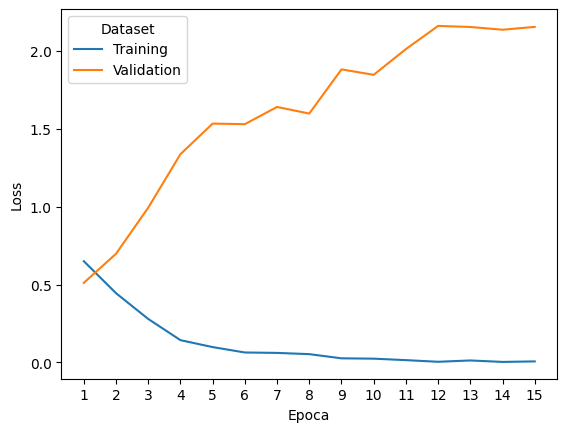

In [33]:
# loss lineplot
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Dataset")
plt.xticks(range(1, 16))
plt.xlabel('Epoca')
plt.savefig(f'loss_curves_{nome}_doppioval.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [34]:
output_predictions = trainer.predict(tokenized_val2)

In [35]:
y_val = tokenized_val2["labels"]
y_val_pred = np.argmax(output_predictions.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.64      0.69      0.67        81
           1       0.68      0.64      0.66        85

    accuracy                           0.66       166
   macro avg       0.66      0.66      0.66       166
weighted avg       0.66      0.66      0.66       166



L'f1-score sul secondo validation è dello 0,66, mentre sul primo era dello 0,75788 :(

In [ ]:
with open(f"class_report_{nome}_doppioval.html", "w") as file:
    file.write(report)

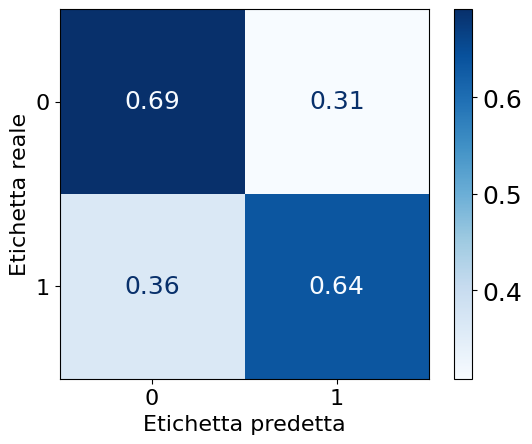

In [36]:
plt.rcParams.update({'font.size': 18})
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, cmap='Blues', normalize='true')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Etichetta predetta', fontsize=16)
plt.ylabel('Etichetta reale', fontsize=16)
plt.savefig(f'conf_matrix_{nome}_doppioval.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [43]:
model_directory = 'BERT_ita-finetuned/checkpoint-966'
# carichiamo il modello della prima epoca, che in verità dovrebbe essere lo stesso che abbiamo salvato durante il training -.-"

In [44]:
model = AutoModelForSequenceClassification.from_pretrained(model_directory)
trainer = Trainer(model=model)
output_prediction_loss = trainer.predict(tokenized_val2)

In [39]:
y_val = tokenized_val2["labels"]
y_val_pred = np.argmax(output_prediction_loss.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.67      0.68        81
           1       0.70      0.73      0.71        85

    accuracy                           0.70       166
   macro avg       0.70      0.70      0.70       166
weighted avg       0.70      0.70      0.70       166



L'f1-score sul secondo validation è dello 0,7, anche se in teoria è lo stesso modello provato prima.